In [6]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling
from keras.layers import Conv2D, MaxPooling2D, Conv3D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers, Input
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop, Adam
import ast
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import os
import cv2
import re
from keras.applications import ResNet50
from keras.applications import VGG19
from tensorflow.keras.models import Model



In [11]:
# Reading and preparing the dataframe
traindf = pd.read_csv('ODIR-5K_Training_multipleLR.csv')
traindf = traindf[['ID', 'labels']]
# traindf['labels'] = traindf['labels'].apply(lambda x: ast.literal_eval(x))
traindfdum = pd.get_dummies(traindf['labels'].apply(pd.Series).stack()).sum(level=0)
traindf = pd.concat([traindf, traindfdum], axis=1)
traindf

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_13648/4060175706.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  traindfdum = pd.get_dummies(traindf['labels'].apply(pd.Series).stack()).sum(level=0)


,ID,labels,"['A', 'H']","['A', 'M']","['A', 'O']",['A'],"['C', 'H']","['C', 'O']",['C'],"['D', 'A', 'O']",...,"['G', 'O']",['G'],"['H', 'O']",['H'],"['M', 'O']",['M'],"['N', 'D', 'O']","['N', 'O']",['N'],['O']
0,0_left.jpg,['C'],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0_right.jpg,['N'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1_left.jpg,['N'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1_right.jpg,['N'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2_left.jpg,"['D', 'O']",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689_right.jpg,['N'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6996,4690_left.jpg,['D'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6997,4690_right.jpg,['D'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6998,4784_left.jpg,"['A', 'H']",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Encode the labels (which are currently strings) to integers
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(traindf['labels'])
print(f"The {len(mlb.classes_)} Label Encoder classes are:\n{mlb.classes_}\nSample of the" 
  f" Multi calss dataset labels:\n{labels}")

The 8 Label Encoder classes are:
['A' 'C' 'D' 'G' 'H' 'M' 'N' 'O']
Sample of the Multi calss dataset labels:
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [12]:
# Change the traindf['labels'] to a string
traindf['labels'] = traindf['labels'].apply(lambda x: str(x))
# Encode the labels (which are currently strings) to integers
le_multi = LabelEncoder()
labels = le_multi.fit_transform(traindf['labels'])
print(f"The {len(le_multi.classes_)} Label Encoder classes are:\n{le_multi.classes_}\nSample of the" 
  f" Multi calss dataset labels:\n{labels}")

The 31 Label Encoder classes are:
["['A', 'H']" "['A', 'M']" "['A', 'O']" "['A']" "['C', 'H']" "['C', 'O']"
 "['C']" "['D', 'A', 'O']" "['D', 'A']" "['D', 'C', 'O']" "['D', 'C']"
 "['D', 'G', 'O']" "['D', 'G']" "['D', 'H']" "['D', 'M']" "['D', 'O']"
 "['D']" "['G', 'A']" "['G', 'C']" "['G', 'H']" "['G', 'M']" "['G', 'O']"
 "['G']" "['H', 'O']" "['H']" "['M', 'O']" "['M']" "['N', 'D', 'O']"
 "['N', 'O']" "['N']" "['O']"]
Sample of the Multi calss dataset labels:
[ 6 29 29 ... 16  0  0]


In [4]:
# # A C D G H M N O
# # Change every item in labels to classes from 0 to 7
# traindf['labels'] = traindf['labels'].apply(lambda x: [0 if i == 'A' else 1 if i == 'C' else 2 if i == 'D' else 3 if i == 'G' else 4 if i == 'H' else 5 if i == 'M' else 6 if i == 'N' else 7 for i in x])

In [3]:
# Convert the labels from A, C,D, G, H, M, n and O to a column of lists
traindf['coded labels'] = traindf.apply(lambda x: [x['A'], x['C'], x['D'], x['G'], x['H'], x['M'], x['N'], x['O']], axis=1)
# traindf['coded labels'] = traindf.apply(lambda x: str(x['A'] + x['C'] + x['D'] + x['G'] + x['H'] + x['M'] + x['N'] + x['O']_, axis=1)

In [4]:
traindf

,ID,labels,A,C,D,G,H,M,N,O,coded labels
0,0_left.jpg,[C],0,1,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0]"
1,0_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]"
2,1_left.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]"
3,1_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]"
4,2_left.jpg,"[D, O]",0,0,1,0,0,0,0,1,"[0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...
6995,4689_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]"
6996,4690_left.jpg,[D],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]"
6997,4690_right.jpg,[D],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]"
6998,4784_left.jpg,"[A, H]",1,0,0,0,1,0,0,0,"[1, 0, 0, 0, 1, 0, 0, 0]"


In [4]:
# Remove jpg extension from ID column
traindf['Name'] = traindf['ID'].apply(lambda x: os.path.splitext(x)[0])
traindf['Name'] = traindf['Name'].str.cat(traindf['labels'].astype(str), sep ="_")

In [5]:
directory = './ODIR-5K_Training_Dataset/'
for item in range(len(traindf['ID'])):
    os.rename(directory + traindf['ID'][item], directory + traindf['Name'][item] + '.jpg')
    

FileNotFoundError: [Errno 2] No such file or directory: './ODIR-5K_Training_Dataset/0_left.jpg' -> "./ODIR-5K_Training_Dataset/0_left_['C'].jpg"

In [ ]:
traindf

,ID,labels,A,C,D,G,H,M,N,O,coded labels,Name
0,0_left.jpg,[C],0,1,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0]","0_left_[0, 1, 0, 0, 0, 0, 0, 0]"
1,0_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","0_right_[0, 0, 0, 0, 0, 0, 1, 0]"
2,1_left.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","1_left_[0, 0, 0, 0, 0, 0, 1, 0]"
3,1_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","1_right_[0, 0, 0, 0, 0, 0, 1, 0]"
4,2_left.jpg,"[D, O]",0,0,1,0,0,0,0,1,"[0, 0, 1, 0, 0, 0, 0, 1]","2_left_[0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689_right.jpg,[N],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","4689_right_[0, 0, 0, 0, 0, 0, 1, 0]"
6996,4690_left.jpg,[D],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]","4690_left_[0, 0, 1, 0, 0, 0, 0, 0]"
6997,4690_right.jpg,[D],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]","4690_right_[0, 0, 1, 0, 0, 0, 0, 0]"
6998,4784_left.jpg,"[A, H]",1,0,0,0,1,0,0,0,"[1, 0, 0, 0, 1, 0, 0, 0]","4784_left_[1, 0, 0, 0, 1, 0, 0, 0]"


In [ ]:
# # Replace the class columns with the corresponding column name instead of 1
# traindf['N'] = traindf['N'].replace(1, 'N')
# traindf['D'] = traindf['D'].replace(1, 'D')
# traindf['G'] = traindf['G'].replace(1, 'G')
# traindf['C'] = traindf['C'].replace(1, 'C')
# traindf['A'] = traindf['A'].replace(1, 'A')
# traindf['H'] = traindf['H'].replace(1, 'H')
# traindf['M'] = traindf['M'].replace(1, 'M')
# traindf['O'] = traindf['O'].replace(1, 'O')

In [ ]:
# for index in traindf.index:
#     traindf.at[index, 'labels'] = list(filter(lambda x: x != 0, traindf.at[index, 'labels']))

In [ ]:
from collections import Counter
labels_count = Counter(label for lbs in traindf['labels'] for label in lbs)

In [ ]:
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}

In [ ]:
# Testing how much images in the new cropped and resized dataset
from pathlib import Path
import os

directory = Path("./squared_and_cropped_dataset")

i = 0
for item in os.listdir(directory):
    i += 1

print(i)

6227


In [ ]:
class_weights

{'C': 24.46527777777778,
 'N': 2.495042492917847,
 'D': 3.9628796400449944,
 'O': 6.359205776173285,
 'H': 36.50777202072539,
 'M': 26.893129770992367,
 'G': 22.511182108626198,
 'A': 25.164285714285715}

In [9]:
img_gen = ImageDataGenerator(rescale=1/224, validation_split=(500/3500))
img_size = (224,224, 3)

In [10]:
# img_iter = img_gen.flow_from_dataframe(
#     traindf,
#     shuffle=True,
#     directory="./ODIR-5K_Training_Dataset/",
#     x_col='ID',
#     y_col='labels',
#     class_mode='categorical',
#     target_size=(224, 224, 3),
#     batch_size=20,
#     subset='training'
# )

# img_iter_val = img_gen.flow_from_dataframe(
#     traindf,
#     shuffle=False,
#     directory="./ODIR-5K_Training_Dataset/",
#     x_col='ID',
#     y_col='labels',
#     class_mode='categorical',
#     target_size=(224, 224 , 3),
#     batch_size=200,
#     subset='validation'
# )

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7000 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7000 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


In [11]:
# from keras.applications import ResNet50
# from keras.applications import VGG19
# from tensorflow.keras.models import Model

# base_model = VGG19(
#     include_top=False,
#     weights='imagenet',
#     input_shape=img_size,
#     # pooling='avg'
# )
# for layer in base_model.layers:
#     layer.trainable = False

# # predictions = Dense(8, activation='sigmoid')(base_model.output)
# # model = Model(inputs=base_model.input, outputs=predictions)
# model = Sequential()
# model.add(Input(shape=(224, 224, 3))) 
# model.add(Rescaling(1./255,input_shape = (224, 224, 3)))
# model.add(base_model)
# model.add(Flatten())
# model.summary()



# # model = Sequential()
# # model.add(Conv2D(input_size=(64, (3, 3)), padding="same", activation="relu"))


In [16]:
train_dir = './ODIR-5K_Training_Dataset/'
test_dir = './ODIR-5K_Testing_Images/'
train_img = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
test_img = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]


In [18]:
# Heb dit gedaan maar nu klopt de volgorde niet meer, of we moeten het op naam gaan matchen rip
# random.shuffle(train_img)
img_size = 224

In [19]:
def preprocess_image(image_list):
    X = []  # images
    y = []  # labels (0 for Normal or 1 for Pneumonia)
    pattern = r'\[([\d,\s]+)\]'

    for image in tqdm(image_list):
        try:
            img = cv2.imread(image)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
            # convert image to 2D to 3D
            # img = np.dstack([img, img, img])
            # convrt greyscale image to RGB
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalalize Image
            img = img.astype(np.float32) / 255.
            X.append(img)

        except:
            continue

        match = re.search(pattern, image)
        extracted_list = match.group(1).split(',')
        extracted_list = [int(i) for i in extracted_list]
        y.append(extracted_list)

    return X, y
    

In [20]:
X_train, y_train = preprocess_image(train_img)


100%|██████████| 7000/7000 [02:52<00:00, 40.61it/s]


In [23]:
len(y_train)

7000

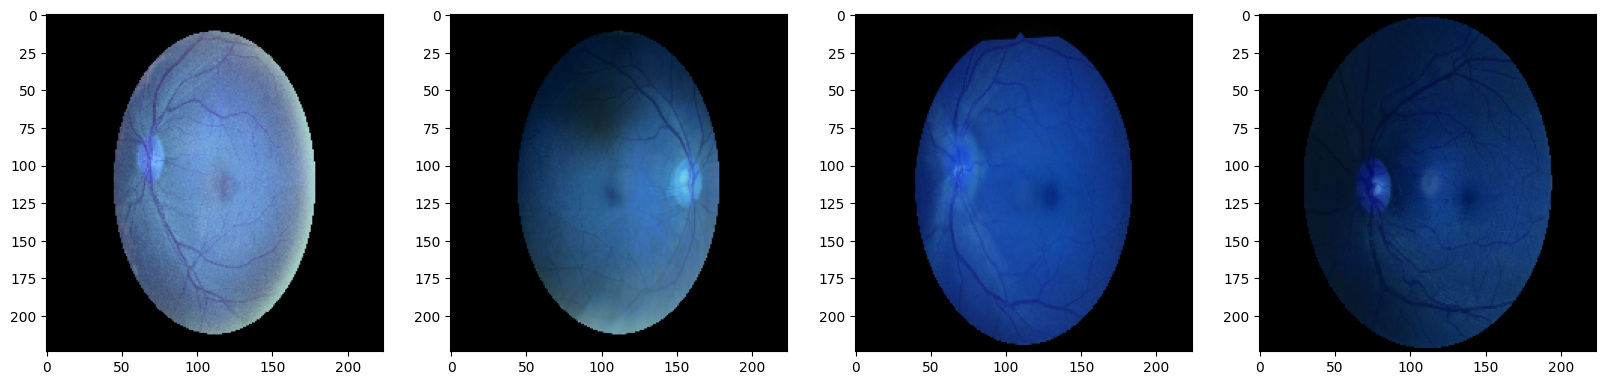

In [24]:
fig = plt.figure(figsize=(20, 5))
k = 1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    plt.imshow(X_train[i])
    k = k + 1
plt.show()

In [25]:
len(y_train)

7000

In [26]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=(500/3500), random_state=42, shuffle=True)

In [27]:
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

X_val = np.asarray(X_validation, dtype=np.float32)
y_val = np.asarray(y_validation, dtype=np.float32)

In [28]:
unique, counts = np.unique(y_train, return_counts=True)
print("The train categories distribution is:\n",dict(zip(unique, counts))) 

unique, counts = np.unique(y_val, return_counts=True)
print("The validation categories distribution is:\n",dict(zip(unique, counts))) 

The train categories distribution is:
 {0.0: 41576, 1.0: 6424}
The validation categories distribution is:
 {0.0: 6928, 1.0: 1072}


In [22]:

train_generator = ImageDataGenerator(rotation_range=5,
                                     horizontal_flip=True,
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     shear_range=0.5,
                                     zoom_range=0.5,
                                    fill_mode='nearest'
                                    )
#Fitting the Image Generator defined above to the X train data set
train_generator.fit(X_train)

In [23]:

IMG_SHAPE = X_train[0].shape
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False

In [24]:

model= Sequential()
model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [25]:

model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))

# Final layer
model.add(Dense(8,activation=('sigmoid')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 8)


Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                   

In [26]:

# Model is saved at the end of every epoch, if it's the best seen so far.
checkpoint_filepath = './Checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
#Initializing the hyperparameters
# Hier gaat het nu fout met de labels :(
batch_size= 2**6
initial_epochs=5 #15
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator.flow(X_train, y_train, batch_size= batch_size),
                    epochs=initial_epochs,
                    validation_data=(X_val,y_val),
                    steps_per_epoch= 20, #len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)


Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 2.5835 - accuracy: 0.2903 INFO:tensorflow:Assets written to: ./Checkpoint/assets


INFO:tensorflow:Assets written to: ./Checkpoint/assets


20/20 [==============================] - 454s 23s/step - loss: 2.5835 - accuracy: 0.2903 - val_loss: 1.7594 - val_accuracy: 0.4410
Epoch 2/5
20/20 [==============================] - 445s 23s/step - loss: 1.9038 - accuracy: 0.4047 - val_loss: 1.7581 - val_accuracy: 0.4410
Epoch 3/5
20/20 [==============================] - 444s 23s/step - loss: 1.8639 - accuracy: 0.4086 - val_loss: 1.7621 - val_accuracy: 0.4410
Epoch 4/5
20/20 [==============================] - 480s 25s/step - loss: 1.8801 - accuracy: 0.3875 - val_loss: 1.7110 - val_accuracy: 0.4410
Epoch 5/5
20/20 [==============================] - 463s 24s/step - loss: 1.8644 - accuracy: 0.3945 - val_loss: 1.7180 - val_accuracy: 0.4410


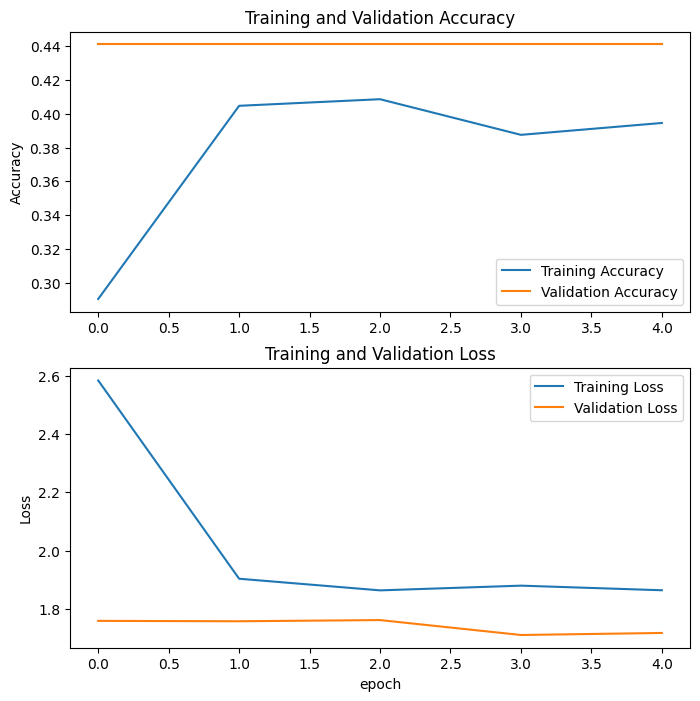

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# _ , accuracy = model.evaluate(x=X_test,y=y_test,batch_size= batch_size,verbose=1)
# print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [36]:
le = LabelEncoder()
labels = le.fit_transform(traindf['labels'])


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['list']

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam'
)

In [31]:
from itertools import tee  # finally! I found something useful for it
from sklearn import metrics
from keras.callbacks import Callback  # Import Callback from keras.callbacks
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score


class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []
        # self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        # duplicate generator to make sure y_true and y_pred are calculated from the same observations
        gen_1, gen_2 = tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        # cohen_kappa = cohen_kappa_score(y_true, y_pred)
        self.val_f1_scores.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)
        # self.val_kappas.append(cohen_kappa)
        print(f" - val_f1_score: {f1:.5f} - val_precision: {precision:.5f} - val_recall: {recall:.5f}")
        return

In [32]:
# Heb deze per ongeluk 2x gerund waardoor de error is, maar het hoort er wel tussen te staan
class_label_to_index = {'C': 0, 'N': 1, 'D': 2, 'O': 3, 'H': 4, 'M': 5, 'G': 6, 'A': 7}
class_weights = {class_label_to_index[label]: weight for label, weight in class_weights.items()}

KeyError: 0

In [33]:
class_weights

{0: 24.46527777777778,
 1: 2.495042492917847,
 2: 3.9628796400449944,
 3: 6.359205776173285,
 4: 36.50777202072539,
 5: 26.893129770992367,
 6: 22.511182108626198,
 7: 25.164285714285715}

In [34]:
metrics = Metrics(img_iter_val, validation_steps=3)
history = model.fit(
    img_iter,
    epochs=5,
    steps_per_epoch=5,
    class_weight=class_weights,
    callbacks=[metrics]
)

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 19.8035

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.08258 - val_precision: 0.05134 - val_recall: 0.21098
5/5 [==============================] - 178s 43s/step - loss: 19.8035


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 22.2087

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.08258 - val_precision: 0.05134 - val_recall: 0.21098
5/5 [==============================] - 162s 39s/step - loss: 22.2087
Epoch 3/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - ETA: 0s - loss: 21.6495

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.08258 - val_precision: 0.05134 - val_recall: 0.21098
5/5 [==============================] - 198s 48s/step - loss: 21.6495
Epoch 4/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - ETA: 0s - loss: 21.7208

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.08258 - val_precision: 0.05134 - val_recall: 0.21098
5/5 [==============================] - 192s 47s/step - loss: 21.7208
Epoch 5/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - ETA: 0s - loss: 24.3112

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2941844854.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.08258 - val_precision: 0.05134 - val_recall: 0.21098
5/5 [==============================] - 185s 45s/step - loss: 24.3112


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


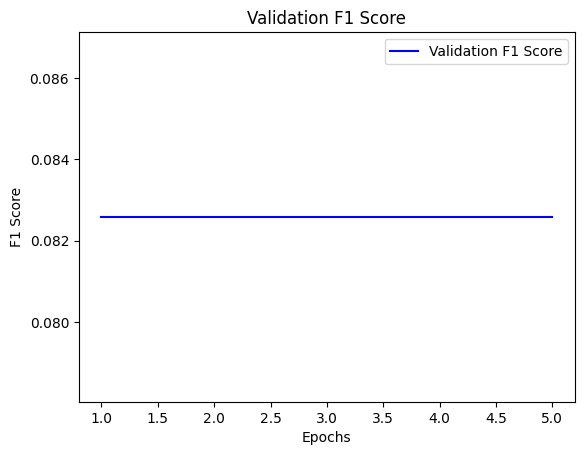

In [36]:
import matplotlib.pyplot as plt

# Access the metrics stored in the Metrics callback
val_f1_scores = metrics.val_f1_scores
val_precisions = metrics.val_precisions
val_recalls = metrics.val_recalls
# val_kappas = metrics.val_kappas

# Plot the metrics
epochs = range(1, len(val_f1_scores) + 1)

plt.plot(epochs, val_f1_scores, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.show()


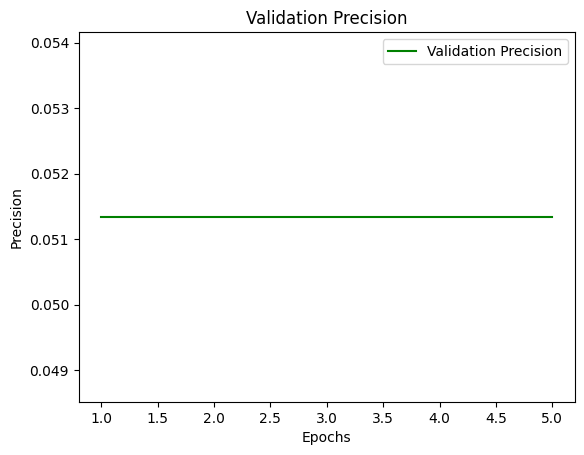

In [37]:
plt.plot(epochs, val_precisions, 'g', label='Validation Precision')
plt.title('Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

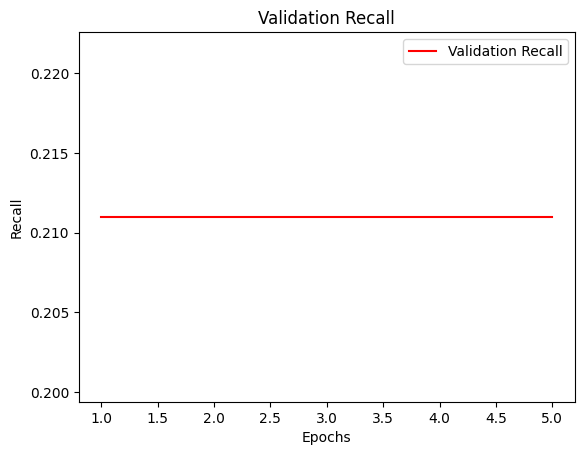

In [38]:
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.title('Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [32]:
index_to_class = {0:'C', 1:'N', 2:'D', 3:'O', 4:'H', 5:'M', 6:'G', 7:'A'}


In [39]:
# https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py 
from sklearn.metrics import ConfusionMatrixDisplay

gen_1, gen_2 = tee(metrics.validation_generator)
y_true = np.vstack(next(gen_1)[1] for _ in range(metrics.validation_steps)).astype('int')
y_pred = (model.predict_generator(gen_2, steps=metrics.validation_steps) > metrics.threshold).astype('int')



/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/595795763.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(metrics.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/595795763.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (model.predict_generator(gen_2, steps=metrics.validation_steps) > metrics.threshold).astype('int')


In [52]:
print(y_pred[1])

[0 0 0 0 0 0 1 0]


In [41]:
label_to_class = {v: k for k, v in img_iter.class_indices.items()}
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

In [42]:
label_to_class

{0: 'A', 1: 'C', 2: 'D', 3: 'G', 4: 'H', 5: 'M', 6: 'N', 7: 'O'}

In [59]:
# Ik snap niet waarom deze het niet doet uuurrrgh
from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=label_to_class.values())

ValueError: multilabel-indicator is not supported

In [44]:
from sklearn.metrics import confusion_matrix
y_true_single = np.argmax(y_true, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

# Calculate the combined confusion matrix
confusion_matrix_all_classes = confusion_matrix(y_true_single, y_pred_single)

# Print or use the confusion matrix as needed
print("Combined Confusion Matrix:")
confusion_matrix_all_classes

Combined Confusion Matrix:


array([[  0,   0,   0,   0,   0,   0,  56,   0],
       [  0,   0,   0,   0,   0,   0,  11,   0],
       [  0,   0,   0,   0,   0,   0, 152,   0],
       [  0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,  21,   0],
       [  0,   0,   0,   0,   0,   0,  18,   0],
       [  0,   0,   0,   0,   0,   0, 145,   0],
       [  0,   0,   0,   0,   0,   0, 192,   0]])

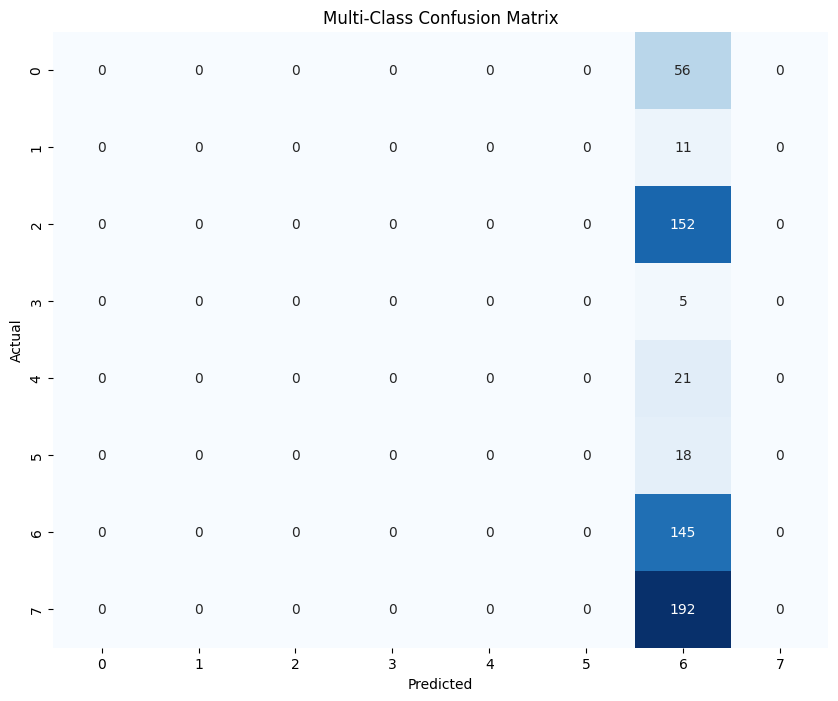

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# After training, calculate the confusion matrix on your validation data
# gen_1, gen_2 = tee(metrics.validation_generator)
# y_true = np.vstack(next(gen_1)[1] for _ in range(metrics.validation_steps)).astype('int')
# y_pred = (model.predict_generator(gen_2, steps=metrics.validation_steps) > metrics.threshold).astype('int')

# Calculate the multi-class confusion matrix
confusion = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-Class Confusion Matrix')
plt.show()

In [46]:

import xml.etree.ElementTree as ET
import itertools
import seaborn as sns
import sys
from sklearn.metrics import multilabel_confusion_matrix


def xml_to_labels(xml_data, unique_labels):
    root = ET.XML(xml_data)
    labels = set() if unique_labels else []
    labels_add = labels.add if unique_labels else labels.append
    for i, child in enumerate(root):
        if child.tag == 'filename':
            img_filename = child.text
        if child.tag == 'object':
            for subchild in child:
                if subchild.tag == 'name':
                    labels_add(subchild.text)
    return img_filename, list(labels)

def get_labels(annotations_dir, unique_labels=True):
    for annotation_file in annotations_dir.iterdir():
        with open(annotation_file) as f:
            yield xml_to_labels(f.read(), unique_labels)
            
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)
    
def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(15, 60))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

In [47]:
pd.set_option('display.max_colwidth', 70)
plt.rcParams['figure.figsize'] = (25, 6)
sns.set(font_scale=2)
sns.set_style('ticks')


/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2117663925.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(nr_batches)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_1014/2117663925.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (model.predict_generator(img_iter_val_1, steps=nr_batches) > threshold).astype('int')


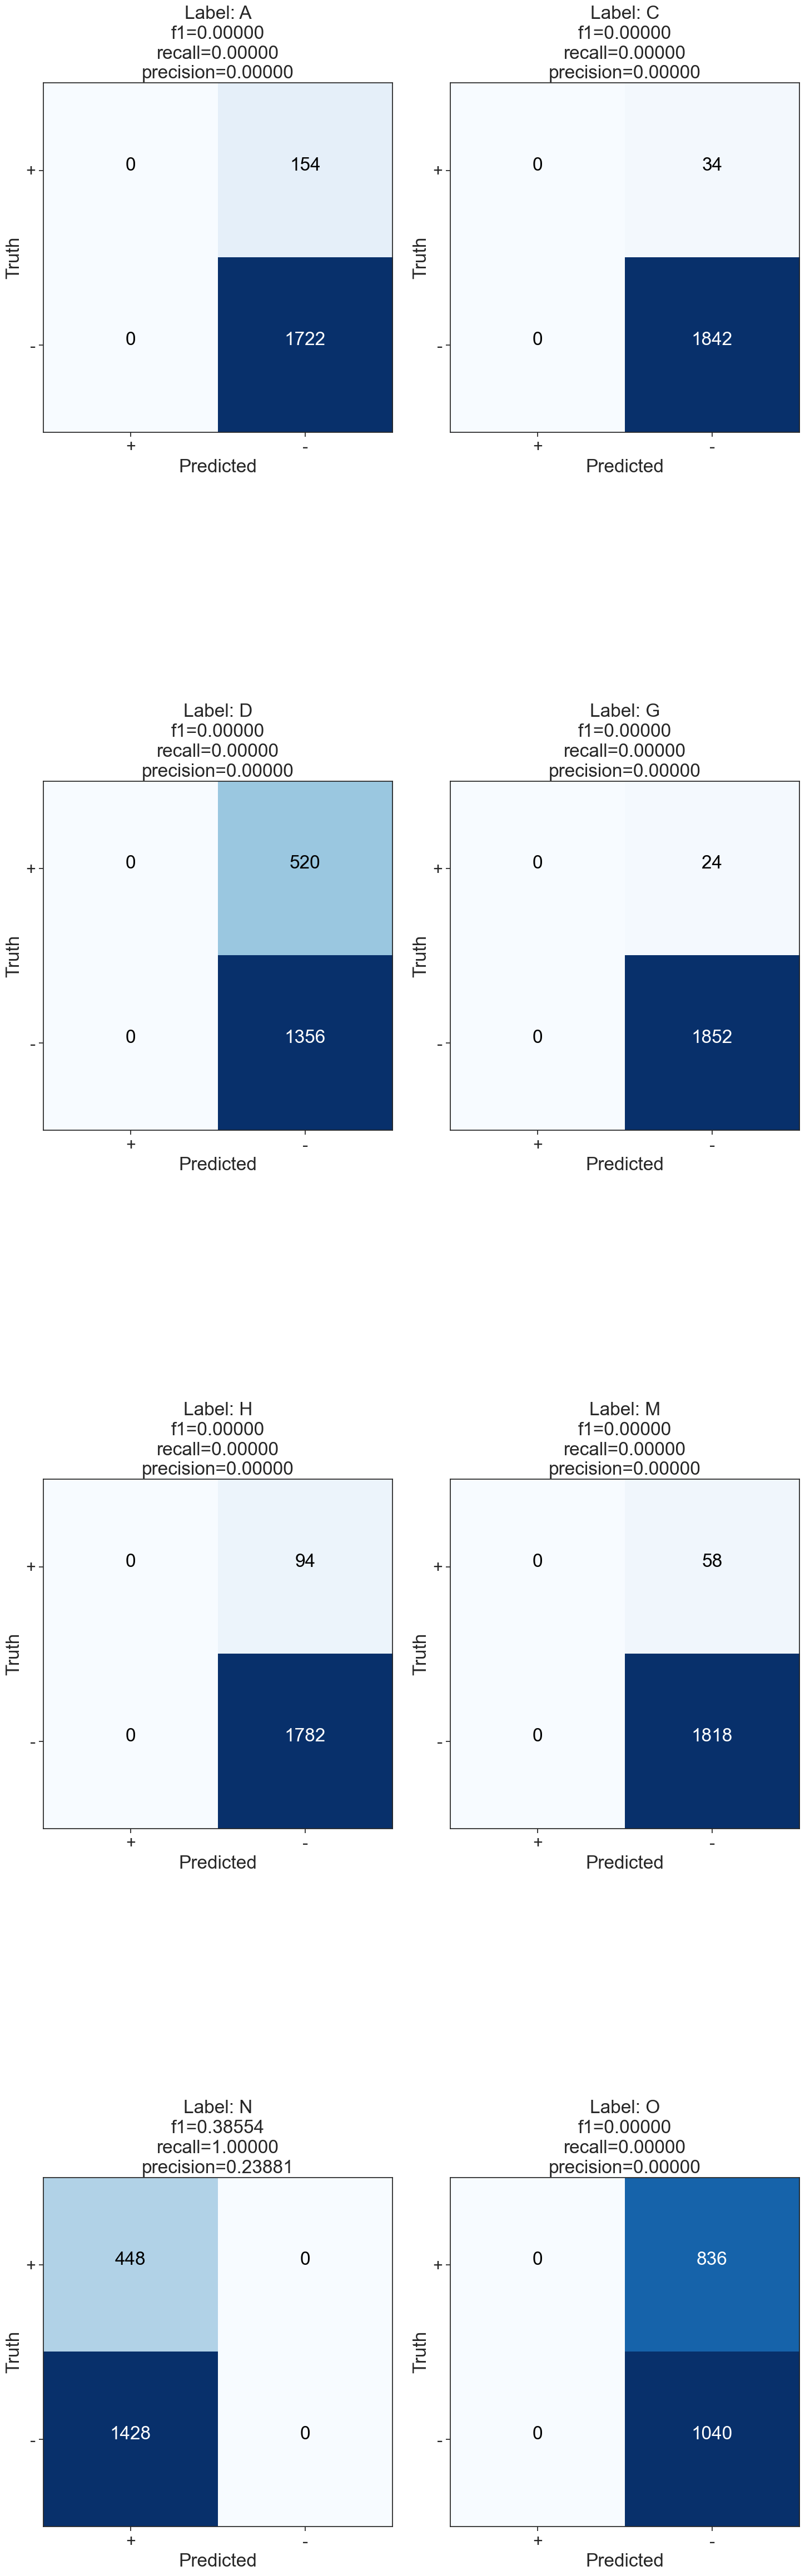

In [48]:
nr_batches = 10
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(img_iter_val, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (model.predict_generator(img_iter_val_1, steps=nr_batches) > threshold).astype('int')
plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False)

HIERONDER ZIJN PROBEERSELS VAN IETS ANDERS. HEBBEN DIT DEELS NODIG OM OOK RESULTATEN VAN DE TESTSET TE KRIJGEN
-
-
-
-
-
-
-
-
-
-


In [74]:
train_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        directory="./ODIR-5K_Training_Dataset/",
        x_col="ID",
        y_col= 'labels',
        subset="training",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        directory="./ODIR-5K_Training_Dataset/",
        x_col="ID",
        y_col= traindf.columns[7:],
        subset="validation",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="./ODIR-5K_Testing_Images/",
        x_col="ID",
        y_col=None,
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(32,32))

Found 6000 validated image filenames.
Found 1000 validated image filenames.
Found 1000 validated image filenames.


In [81]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(8, activation='sigmoid'))  # 8 is the number of label columns
model.add(Dropout(0.5))

# Compile the model with binary_crossentropy for multi-label classification
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_6202/3771039389.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_6202/3771039389.py", line 4, in <module>
      model.fit_generator(generator=train_generator,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2810, in fit_generator
      return self.fit(
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs'
Incompatible shapes: [32,128] vs. [32,8]
	 [[{{node gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_7390]